In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "Rock17st@r",
                            database = "ecommerce")
cur = db.cursor()

# List all unique cities where customers are located.

In [2]:
query = """ select distinct(customer_city) from customers """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.

In [3]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017  """

cur.execute(query)

data = cur.fetchall()

data[0][0]

45101

# Find the total sales per category.

In [4]:
query = """ select products.product_category category,
round(sum(payments.payment_value), 2) sales 
from  products join order_items
on products.product_id = order_items.product_id
join payments  
on payments.order_id = order_items.order_id
group by category """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category", "Sales"])

df

,Category,Sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,bed table bath,1712553.67
4,automotive,852294.33
...,...,...
69,cds music dvds,1199.43
70,La Cuisine,2913.53
71,Fashion Children's Clothing,785.67
72,PC Gamer,2174.43


In [5]:
query = """  select products.product_category category, round(sum((order_items.price + order_items.freight_value)), 2) Sales
 from products join order_items 
 on products.product_id = order_items.product_id 
 group by category """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category" , "Sales"])

df

,Category,Sales
0,HEALTH BEAUTY,1441248.07
1,sport leisure,1156656.48
2,Cool Stuff,719329.95
3,computer accessories,1059272.40
4,Watches present,1305541.61
...,...,...
69,flowers,1598.91
70,Kitchen portable and food coach,4278.29
71,House Comfort 2,1170.58
72,CITTE AND UPHACK FURNITURE,5998.54


# Calculate the percentage of orders that were paid in installments

In [6]:
query = """ Select (sum(case when payment_installments > 1 then 1 else 0 end)) / count(*) *100 from payments """

cur.execute(query)

data = cur.fetchall()

data[0][0]

Decimal('49.4176')

# Count the number of customers from each state. 

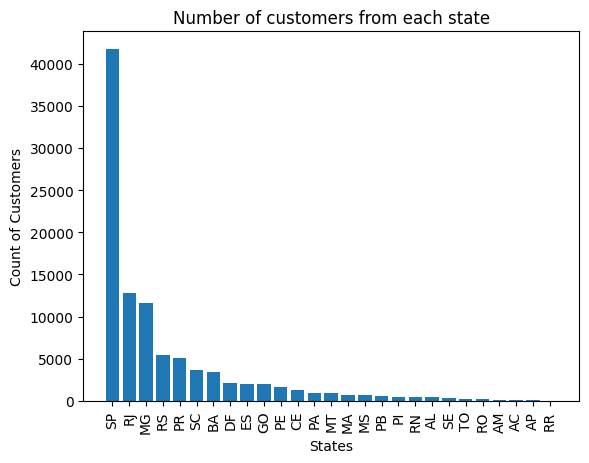

In [7]:
query = """ Select customer_state, count(customer_id) from customers group by customer_state """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["State","Count"])
df = df.sort_values(by  = "Count", ascending = False)

plt.xticks(rotation = 90)
plt.bar(df["State"], df["Count"])
plt.xlabel("States")
plt.ylabel("Count of Customers")
plt.title("Number of customers from each state")
plt.show()

# Intermediate Queries
# 1. Calculate the number of orders per month in 2018.

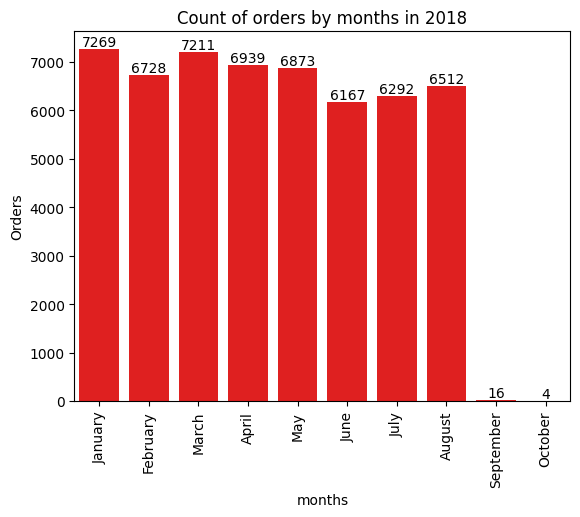

In [8]:
query = """ select monthname(order_purchase_timestamp) months , count(order_id) Orders_count from Orders where year(order_purchase_timestamp) = 2018
group by months """

cur.execute(query)

data = cur.fetchall()

df= pd.DataFrame(data, columns = ["months", "Orders"])
#df= df.sort_values(by = "Orders", ascending = False)
o =["January","February","March","April","May","June","July","August","September","October"]

ax =sns.barplot(x =df["months"], y= df["Orders"], data = df , order= o, color ="red")
plt.xticks(rotation =90)
plt.title("Count of orders by months in 2018")
ax.bar_label(ax.containers[0])
plt.show()


#  Find the average number of products per order, grouped by customer city.

In [9]:
query = """ with count_per_order as (select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city
order by average_orders desc
 """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data)
df.head(10)

,0,1
0,padre carvalho,7.00
1,celso ramos,6.50
2,candido godoi,6.00
3,datas,6.00
4,matias olimpio,5.00
5,morro de sao paulo,4.00
6,cidelandia,4.00
7,picarra,4.00
8,teixeira soares,4.00
9,curralinho,4.00


#  Calculate the percentage of total revenue contributed by each product category

In [10]:
query = """select products.product_category category, round(sum(payments.payment_value)/(select sum(payment_value) from payments)*100,2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category
order by sales desc """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Produc_Category", "Percentage_in_Sales"])
df

,Produc_Category,Percentage_in_Sales
0,bed table bath,10.70
1,HEALTH BEAUTY,10.35
2,computer accessories,9.90
3,Furniture Decoration,8.93
4,Watches present,8.93
...,...,...
69,House Comfort 2,0.01
70,cds music dvds,0.01
71,PC Gamer,0.01
72,Fashion Children's Clothing,0.00



# Identify the correlation between product price and the number of times a product has been purchased.

In [11]:
query = """ select products.product_category, count(order_items.product_id), avg(order_items.price)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category """

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns =["Category", "order_count", "Price"])

arr1 = df["order_count"]
arr2 = df["Price"]

a = np.corrcoef(arr1,arr2)
print(a[0][1])

-0.10631552237549534


# Calculate the total revenue generated by each seller, and rank them by revenue.

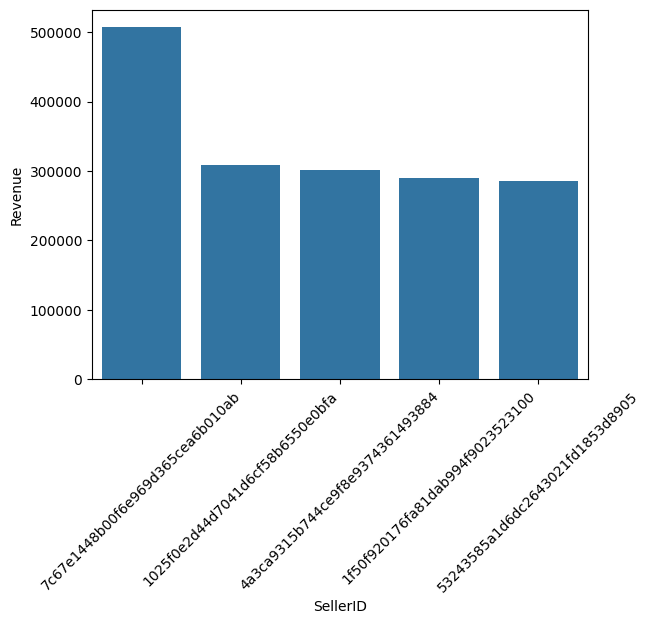

In [12]:
query= """ select * , dense_rank() over(order by revenue desc) as rnk from
(select order_items.seller_id, sum(payments.payment_value) revenue
from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns =["SellerID", "Revenue", "Rank"])

df = df.head()
sns.barplot(x = "SellerID", y = "Revenue", data = df)
plt.xticks(rotation = 45)
plt.show()